In [1]:
!pip install yfinance numpy pandas scikit-learn tensorflow keras-tuner scikit-optimize matplotlib


In [2]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError
from sklearn.metrics import r2_score, explained_variance_score
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt


In [3]:
# Fetch the data
ticker_symbol = "MQG.AX"
westpac = yf.Ticker(ticker_symbol)
data = westpac.history(period="10y", interval="1wk")


In [4]:

# define target value (closing price of the next day)
data['Target'] = data['Close'].shift(-1) # -1 used to used next day's price as target
print(data)

                                 Open        High         Low       Close  \
Date                                                                        
2014-05-26 00:00:00+10:00   39.357968   39.416556   39.025972   39.078049   
2014-06-02 00:00:00+10:00   39.078051   39.442598   38.414056   39.123619   
2014-06-09 00:00:00+10:00   39.123618   39.572793   38.863229   39.045502   
2014-06-16 00:00:00+10:00   38.993422   39.833179   38.778599   39.384007   
2014-06-23 00:00:00+10:00   39.423066   39.813651   38.804639   39.357967   
...                               ...         ...         ...         ...   
2024-04-29 00:00:00+10:00  184.578419  184.862636  179.707422  180.168060   
2024-05-06 00:00:00+10:00  178.237300  189.733631  177.247425  189.420013   
2024-05-13 00:00:00+10:00  186.303348  189.959056  183.010280  187.058014   
2024-05-20 00:00:00+10:00  191.320007  196.179993  190.610001  192.210007   
2024-05-27 00:00:00+10:00  194.080002  194.449997  188.389999  189.479996   

In [5]:
# add indicators

# SMA-10
data['SMA_10'] = data['Close'].rolling(window=10).mean().shift(1)
# SMA 25
data['SMA_25'] = data['Close'].rolling(window=25).mean().shift(1)

# Momentum (Close price difference shifted by 1 to use previous day's data)
data['Momentum'] = data['Close'].diff().shift(1)

# Stochastic %K and %D using data up to the previous day
low_min = data['Low'].rolling(window=14).min().shift(1)
high_max = data['High'].rolling(window=14).max().shift(1)
data['Stochastic_%K'] = ((data['Close'].shift(1) - low_min) / (high_max - low_min)) * 100
data['Stochastic_%D'] = data['Stochastic_%K'].rolling(window=3).mean()

# RSI calculated from previous days
delta = data['Close'].diff(1).shift(1)
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
data['RSI'] = 100 - (100 / (1 + rs))

# MACD calculation shifted to include only past data
exp1 = data['Close'].ewm(span=12, adjust=False).mean().shift(1)
exp2 = data['Close'].ewm(span=26, adjust=False).mean().shift(1)
macd = exp1 - exp2
signal = macd.ewm(span=9, adjust=False).mean()
data['MACD'] = macd
data['MACD_Signal'] = signal

# list of columns
columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
           'Target', 'SMA_10', 'SMA_25', 'Momentum', 'Stochastic_%K', 'Stochastic_%D', 'RSI',
           'MACD', 'MACD_Signal']

# reorder columns to put 'Target' in the end
columns.remove('Target')
columns.append('Target')
data= data[columns]



                                Open       High        Low      Close  \
Date                                                                    
2014-05-26 00:00:00+10:00  39.357968  39.416556  39.025972  39.078049   
2014-06-02 00:00:00+10:00  39.078051  39.442598  38.414056  39.123619   
2014-06-09 00:00:00+10:00  39.123618  39.572793  38.863229  39.045502   
2014-06-16 00:00:00+10:00  38.993422  39.833179  38.778599  39.384007   
2014-06-23 00:00:00+10:00  39.423066  39.813651  38.804639  39.357967   
2014-06-30 00:00:00+10:00  39.442595  39.631379  38.296880  39.344948   
2014-07-07 00:00:00+10:00  39.397024  39.449101  38.101582  38.576794   
2014-07-14 00:00:00+10:00  38.648414  39.165940  38.283869  39.058529   
2014-07-21 00:00:00+10:00  39.227775  39.885261  38.003943  38.160175   
2014-07-28 00:00:00+10:00  37.567791  38.101591  37.170696  37.567791   
2014-08-04 00:00:00+10:00  37.463632  37.750062  35.998937  36.226780   
2014-08-11 00:00:00+10:00  36.584818  37.379006  36

In [6]:
# delete rows with null/nan values
data = data.dropna()

In [7]:
contains_nan = data.isna().any().any()
print("Contains NaN:", contains_nan)

num_rows_with_nan = data.isna().any(axis=1).sum()
print("Number of rows with NaN:", num_rows_with_nan)

Contains NaN: False
Number of rows with NaN: 0


In [8]:

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Split data into features and target
features = scaled_data[:, :-1]
target = scaled_data[:, -1]




# Reshape features for LSTM Layer
features = np.reshape(features, (features.shape[0], 1, features.shape[1]))

# Splitting data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


split_idx = int(len(features) * 0.7)

# Split the features into training and testing sets
X_train = features[:split_idx]
X_test = features[split_idx:]


# Split the target into training and testing sets
y_train = target[:split_idx]
y_test = target[split_idx:]


In [9]:
def build_model(hp):
    model = Sequential()
    model.add(LSTM(
        units=hp.Int('units_lstm1', min_value=32, max_value=128, step=16),
        return_sequences=True,
        input_shape=(X_train.shape[1], X_train.shape[2])
    ))
    model.add(LSTM(
        units=hp.Int('units_lstm2', min_value=32, max_value=128, step=16)
    ))
    model.add(Dense(1))
    
    model.compile(
        optimizer=Adam(
            learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        ),
        loss='mean_squared_error'
    )
    return model

# Initialize the Bayesian tuner
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_mean_absolute_error',
    max_trials=20,
    directory='my_dir',
    project_name='rnn_optimization'
)


# Run the hyperparameter search
tuner.search(
    X_train, y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    batch_size=20,
    verbose=1
)
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters
model = tuner.hypermodel.build(best_hps)

# Train the model with the full training data
model.fit(X_train, y_train, epochs=50, batch_size=20, validation_data=(X_test, y_test), verbose=1)


Reloading Tuner from my_dir\rnn_optimization\tuner0.json

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
128               |128               |units_lstm1
32                |32                |units_lstm2
0.001             |0.001             |learning_rate


Epoch 1/50


C:\Users\Kirill\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



 1/18 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - loss: 0.0864

Traceback (most recent call last):
  File "C:\Users\Kirill\anaconda3\Lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Kirill\anaconda3\Lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Kirill\anaconda3\Lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Kirill\anaconda3\Lib\site-packages\keras_tuner\src\engine\tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Kirill\a

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "C:\Users\Kirill\anaconda3\Lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "C:\Users\Kirill\anaconda3\Lib\site-packages\keras_tuner\src\engine\base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Kirill\anaconda3\Lib\site-packages\keras_tuner\src\engine\tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Kirill\anaconda3\Lib\site-packages\keras_tuner\src\engine\tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Kirill\anaconda3\Lib\site-packages\keras_tuner\src\engine\hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Kirill\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\Kirill\anaconda3\Lib\site-packages\keras_tuner\src\engine\tuner_utils.py", line 76, in on_epoch_end
    self._save_model()
  File "C:\Users\Kirill\anaconda3\Lib\site-packages\keras_tuner\src\engine\tuner_utils.py", line 86, in _save_model
    self.model.save_weights(write_filepath)
AttributeError: 'NoneType' object has no attribute 'File'


In [13]:


model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(50),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')


model.fit(X_train, y_train, epochs=50, batch_size=20, validation_data=(X_test, y_test), verbose=1)


Epoch 1/50


C:\Users\Kirill\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0423 - val_loss: 0.0372
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.8317e-04 - val_loss: 0.0048
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8061e-04 - val_loss: 0.0035
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.1281e-04 - val_loss: 0.0020
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.8798e-04 - val_loss: 0.0029
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6007e-04 - val_loss: 0.0030
Epoch 9/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9574e-04 - val_loss: 0.0059
Epoch 10/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.3784e-04 - val_loss: 0.0018
Epoch 11/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.4711e-04 - val_loss: 0.0027
Epoch 12/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step -

In [12]:
predictions = model.predict(X_test) # MQG.AX stock

# evaluation
y_pred = predictions
 # MQG.AX stock



explained_variance = explained_variance_score(y_test, predictions)
print("Explained Variance Score:", explained_variance)


# Mean Squared Error (MSE)
mse = MeanSquaredError()
mse.update_state(y_test, y_pred)
mse_result = mse.result().numpy()
print("Mean Squared Error (MSE):", mse_result)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse_result)
print("Root Mean Squared Error (RMSE):", rmse)

# Mean Absolute Error (MAE)
mae = MeanAbsoluteError()
mae.update_state(y_test, y_pred)
mae_result = mae.result().numpy()
print("Mean Absolute Error (MAE):", mae_result)

# r^2
r2 = r2_score(y_test, y_pred)
print("R^2 (Coefficient of Determination):", r2)

# Calculate Mean Bias Deviation (MBD)
def mean_bias_deviation(y_true, y_pred):
    differences = y_true - y_pred
    mbd = np.mean(differences)
    return mbd

# Calculate MBD for the test set
mbd = mean_bias_deviation(y_test, y_pred)
print("Mean Bias Deviation:", mbd)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Explained Variance Score: 0.632779385977839
Mean Squared Error (MSE): 0.004680042
Root Mean Squared Error (RMSE): 0.068410836
Mean Absolute Error (MAE): 0.055633493
R^2 (Coefficient of Determination): 0.2729845017973268
Mean Bias Deviation: 0.04812608814612783


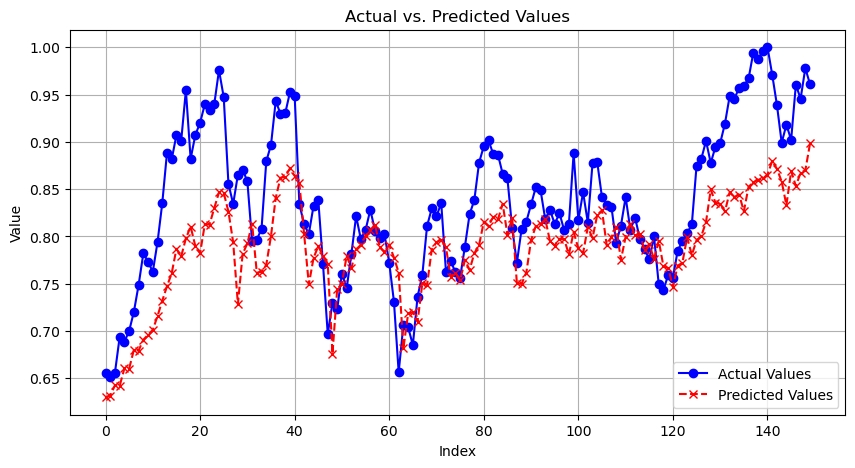

In [14]:
# plot results for macquarie group stock
y_test = np.array(y_test)
predictions = np.array(predictions)

plt.figure(figsize=(10, 5))
plt.plot(range(len(y_test)), y_test, label='Actual Values', color='blue', marker='o')
plt.plot(range(len(predictions)), predictions, label='Predicted Values', color='red', linestyle='--', marker='x')
plt.title('Actual vs. Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()